In [167]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [168]:
df = pd.read_csv('final_clean.csv').sort_values('GAME_ID')
df = df.dropna()
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE_HOME'])
#df = df.set_index('GAME_ID')

# Define a target column
df['AVG_SPREAD_mean'] = df['PLUS_MINUS_mean_HOME'] - df['PLUS_MINUS_mean_AWAY']
df['ACTUAL_SPREAD'] = df['PLUS_MINUS_HOME']

In [169]:
def select_season(season):
    prefix = {'2012-13':'212', '2013-14':'213', '2014-15':'214',
             '2015-16':'215', '2016-17':'216'}
    return df[df['GAME_ID'].astype(str).str.startswith(prefix[season])]

def select_seasons(seasons):
    result = pd.DataFrame()
    for season in seasons:
        result = pd.concat([result, select_season(season)])
    return result

df_train = select_seasons(['2012-13','2013-14','2014-15'])
df_val = select_seasons(['2015-16'])
df_test = select_seasons(['2016-17'])

In [170]:
# Preprocessing here
from sklearn.preprocessing import StandardScaler

numerical_cols = [c for c in df_train.columns if 'mean' in c or 'avg' in c and 'PLUS_MINUS' not in c and 'AVG_SPREAD' not in c]

for col in numerical_cols:
    scl = StandardScaler()
    df_train[col] = scl.fit_transform(df_train[col].as_matrix().reshape(-1,1)) # may want to fit on both validation and train
    # assign val and test
    df_val[col] = scl.transform(df_val[col].as_matrix().reshape(-1,1))
    df_test[col] = scl.transform(df_test[col].as_matrix().reshape(-1,1))

In [171]:
def betting_metric(y_pred, y_actual):
    # +1 for good outcome, -1 for bad outcome
    return (2*(y_pred < y_actual).astype(int) - 1)

# quick test
# betting_metric(np.array([2,3,-3,-2]),np.array([3,2,-2,-3]))

In [172]:
# One metric is fraction correct (accuracy score)
def fraction_correct(y_pred, y_actual):
    print y_pred.shape
    counts =  pd.Series(betting_metric(y_pred, y_actual).ravel()).value_counts()
    return float(counts.loc[1])/counts.sum()

# This is the "base modeL"
print betting_metric(df['AVG_SPREAD_mean'], df['PLUS_MINUS_HOME']).mean()
print betting_metric(df['AVG_SPREAD_mean'], df['PLUS_MINUS_HOME']).value_counts()

print fraction_correct(df['AVG_SPREAD_mean'], df['PLUS_MINUS_HOME'])
# Not meaningful, but interesting to see whether AWAY point spread helps.
# print betting_metric(df['PLUS_MINUS_mean_HOME'], df['PLUS_MINUS_HOME']).mean()

0.172880237545
 1    3555
-1    2507
dtype: int64
(6062L,)
0.586440118773


In [173]:
numerical_cols = list(set(numerical_cols) - set(['PLUS_MINUS_mean_AWAY', 'PLUS_MINUS_mean_HOME','ACTUAL_SPREAD']))

In [192]:
from sklearn.linear_model import LinearRegression, Lasso

X_train = df_train[numerical_cols].as_matrix()
y_train = df_train['ACTUAL_SPREAD'].as_matrix().reshape(-1,1)
linreg = LinearRegression()
lasso = Lasso(alpha=0.1)
linreg.fit(X_train, y_train)
lasso.fit(X_train, y_train)
#print linreg.coef_
print "Linear model"
y_train_pred = linreg.predict(X_train)
print fraction_correct(y_train_pred, y_train)

print ""
print "Lasso"
y_train_pred = lasso.predict(X_train)
print fraction_correct(y_train_pred, y_train)
print np.sum(lasso.coef_==0).astype(float) / lasso.coef_.shape[0]

Linear model
(3635L, 1L)
0.505639614856

Lasso
(3635L,)
0.506912279175
0.672


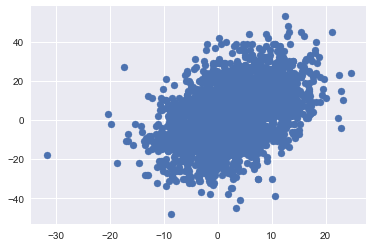

In [175]:
plt.scatter(y_train_pred, y_train)

Random Forest
(3635L,)
0.498282137782


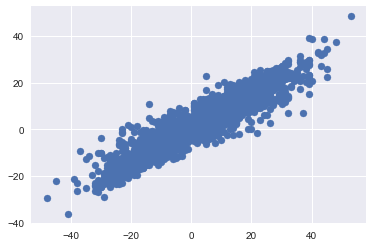

In [196]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor() # todo: hyperparameter search...

rf.fit(X_train, y_train.ravel())
print "Random Forest"
y_train_pred = rf.predict(X_train)
print fraction_correct(y_train_pred, y_train)
plt.scatter(y_train, y_train_pred)

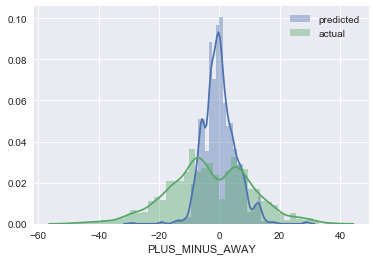

In [24]:
sns.distplot(df['PLUS_MINUS_mean_AWAY'].dropna(), label='predicted')
sns.distplot(df['PLUS_MINUS_mean'].dropna(), label='actual')
plt.legend()

In [ ]:
# StandardScaler for rescaling numerical columns
# Exploratory plots and sanity checks
